In [1]:
import numpy as np
import pandas as pd

# Dataset
We run through the following steps:
1. Import the dataset from Kaggle and load into a `pd.DataFrame`
2. Extract the images and labels from the `pd.DataFrame`

In [2]:
data = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv", dtype="float32")
X = data.drop(columns="0").astype("float32").divide(255)
y = data["0"].astype("int64").add(10)

In [3]:
def label_to_string(y:int)->str:
  if y < 10:
      return str(y.numpy())
  return chr(y-10+ord("A"))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import torchvision
from torch.utils.data import ConcatDataset, Dataset

class HandwritingDataset(Dataset):
    def __init__(self, X: pd.DataFrame, y: pd.Series, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X.iloc[idx,:].values.reshape(28, 28)
        label = self.y.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transform = torchvision.transforms.ToTensor()
train_dataset = ConcatDataset([HandwritingDataset(X_train, y_train, transform=transform), torchvision.datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)])
test_dataset = ConcatDataset([HandwritingDataset(X_test, y_test, transform=transform), torchvision.datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)])

In [6]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# put into batches
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [8]:
data_loader = torch.utils.data.DataLoader(HandwritingDataset(X_test.iloc[:100], y_test.iloc[:100], transform=transform), batch_size=1)
img, lab = list(data_loader)[0]

In [9]:
class VAE(nn.Module):
    def __init__(self, input_size:int, output_size:int, num_filters:int, num_latent_var: int):
        super(VAE, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_latent_var = num_latent_var
        self.input_encoder = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Flatten()
                    )

        encoder_output_dim = (num_filters, 7, 7)
        encoder_output_size = int(np.prod(encoder_output_dim))
        self.y_encoder = nn.Sequential(nn.Linear(encoder_output_size, 128), nn.ReLU(), nn.Linear(128, output_size))
        self.z_mean = nn.Linear(encoder_output_size, num_latent_var)
        self.log_z_var = nn.Linear(encoder_output_size, num_latent_var)

        self.y_decoder = nn.Sequential(nn.Linear(output_size, 128), nn.ReLU(), nn.Linear(128, encoder_output_size), nn.ReLU())
        self.z_decoder = nn.Linear(num_latent_var, encoder_output_size)

        self.output_decoder = nn.Sequential(
            nn.Unflatten(1, encoder_output_dim),
            nn.ConvTranspose2d(in_channels=num_filters, out_channels=num_filters, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=num_filters, out_channels=1, kernel_size=4, stride=2, padding=1),
        )

    def encode(self, x):
        x = self.input_encoder(x)
        y_pred = self.y_encoder(x)
        z_mean = self.z_mean(x)
        log_z_var = self.log_z_var(x)
        return y_pred, z_mean, log_z_var

    def forward(self, x):
        y_pred, z_mean, log_z_var = self.encode(x)
        std = log_z_var.mul(0.5).exp_()
        epsilon = torch.randn(*z_mean.size()).to(device)
        z = z_mean + std * epsilon
        x_hat = self.decode(z, y_pred.softmax(axis=-1))
        return x_hat, z_mean, log_z_var, y_pred

    def decode(self, z, y):
        x = self.z_decoder(z) + self.y_decoder(y)
        return self.output_decoder(x)

    def loss(self, x, y):
        x_hat, z_mean, log_z_var, y_pred = self.forward(x)
        cat_loss = nn.CrossEntropyLoss()(y_pred, y)
        recon_loss = nn.BCEWithLogitsLoss()(x_hat, x)
        kl_div_loss = -0.5 * torch.sum(1 + log_z_var - z_mean.pow(2) - log_z_var.exp()) / x.shape[0]
        return cat_loss, recon_loss, kl_div_loss

In [10]:
model = VAE(input_size=28, output_size=10+26, num_filters=32, num_latent_var=64).to(device)
optimiser = torch.optim.Adam(model.parameters())

In [11]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    minloss = 1
    running_kl_div_loss = 0
    running_recons_loss = 0
    running_cat_loss = 0
    num_images = 0
    for i, (img, label) in enumerate(train_loader):
        img = img.to(device)
        label = label.to(device)
        optimiser.zero_grad()
        cat_loss, recons_loss, kl_div_loss = model.loss(img, label)
        loss =  0.1 * cat_loss + recons_loss + epoch * 0.001 * kl_div_loss
        loss.backward()
        optimiser.step()
        running_cat_loss = running_cat_loss + cat_loss.item() * len(img)
        running_recons_loss = running_recons_loss + recons_loss.item() * len(img)
        running_kl_div_loss = running_kl_div_loss +  kl_div_loss.item() * len(img)

        num_images = num_images + len(img)
    print(
        'epoch: '
        + str(epoch)
        + ' cat_loss: '
        + str(running_cat_loss / num_images)
        + ' recons_loss: '
        + str(running_recons_loss / num_images)
        + ' kl_div_loss: '
        + str(running_kl_div_loss / num_images)
    )

epoch: 1 cat_loss: 0.19285366980869734 recons_loss: 0.1186471494666317 kl_div_loss: 32.61286878110257
epoch: 2 cat_loss: 0.08798051820251761 recons_loss: 0.12622077803376508 kl_div_loss: 19.00447137559615
epoch: 3 cat_loss: 0.05932446556975973 recons_loss: 0.1374409960863217 kl_div_loss: 12.902384787578798
epoch: 4 cat_loss: 0.04532030529048867 recons_loss: 0.1460952264501444 kl_div_loss: 9.687018308406143
epoch: 5 cat_loss: 0.03741227578794964 recons_loss: 0.153355308289181 kl_div_loss: 7.703251578754814
epoch: 6 cat_loss: 0.03287699799371981 recons_loss: 0.15962228383654548 kl_div_loss: 6.304598687590001
epoch: 7 cat_loss: 0.03235722613265793 recons_loss: 0.16491400706080675 kl_div_loss: 5.255497616391593
epoch: 8 cat_loss: 0.03805792460393222 recons_loss: 0.16869271144625567 kl_div_loss: 4.402467603147437
epoch: 9 cat_loss: 0.050707134899302606 recons_loss: 0.17085775117598934 kl_div_loss: 3.629131366293022
epoch: 10 cat_loss: 0.07312557369479754 recons_loss: 0.17048375712205396 kl_

# Assessing model accuracy
We can evaluate the binary accuracy of the reconstructed images.

In [12]:
from torchmetrics.classification import Accuracy

x_truths = []
x_recons = []
z_means = []
log_z_vars = []
y_truths = []
y_preds = []
cat_accuracies = []
recon_accuracies = []

cat_metric = Accuracy(task='multiclass', num_classes=model.output_size)
recon_metric = Accuracy(task='binary', threshold=0.5)

for im, y_true in test_loader:
    x_recon, z_mean, log_z_var, ysoft = model.forward(im.to(device))
    _,y_pred  = torch.max(ysoft, 1)
    x_truths.append(im)
    x_recons.append(x_recon)
    z_means.append(z_mean)
    log_z_vars.append(log_z_var)
    y_truths.append(y_true)
    y_preds.append(y_pred)

    cat_accuracies.append(cat_metric(y_pred.cpu(), y_true))
    recon_accuracies.append(recon_metric(x_recon.cpu(), im>0.5))


print("Cat. acc: {}".format(sum(cat_accuracies)/len(cat_accuracies)))
print("Recon. acc: {}".format(sum(recon_accuracies)/len(recon_accuracies)))

Cat. acc: 0.5277133584022522
Recon. acc: 0.9084426164627075


We can get a more qualitative assessment by comparing the original and reconstructed images.

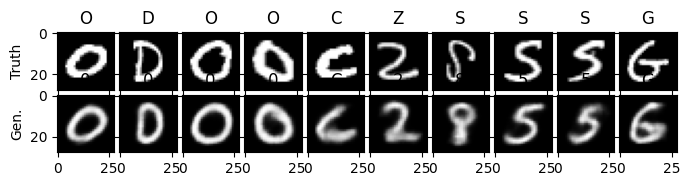

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8.0, 10.0))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 10), axes_pad=0.05)

for ax,im, y_true in zip(grid[:10], x_truths[0].cpu().detach(), y_truths[0].cpu().detach()):
    ax.imshow(im.squeeze(), cmap='gray')
    ax.set_title(label_to_string(y_true))
grid[0].set_ylabel("Truth")

for ax, im, y_pred in zip(grid[10:], x_recons[0].cpu().detach(), y_preds[0].cpu().detach()):
    ax.imshow(im.squeeze().sigmoid(), cmap='gray')
    ax.set_title(label_to_string(y_pred))
grid[10].set_ylabel("Gen.")

plt.show()

# Generation of hand-writing
Let us now use the decoder to general some artificial handwriting.
- Determine the hand-writing style (in terms of latent variables) from the first 6 items in the test set
- Generate the characters for each of these styles

In [14]:
labels = torch.arange(0, model.output_size)
y_plot = nn.functional.one_hot(labels.reshape(-1,1).tile(1,6).flatten()).float().to(device)

def _sample_latent_var(z_mean:torch.Tensor, log_z_var:torch.Tensor)->torch.Tensor:
    e = 0*torch.randn(*z_mean.shape).to(device)
    std = log_z_var.mul(0.5).exp_()
    return z_mean + e * std

z_mean_to_plot = z_means[0][:6]
log_z_var_to_plot = log_z_vars[0][:6]
z_plot = _sample_latent_var(z_mean_to_plot, log_z_var_to_plot).tile(model.output_size,1)
generated_images = model.decode(z_plot, y_plot).sigmoid().reshape(-1, model.input_size, model.input_size)

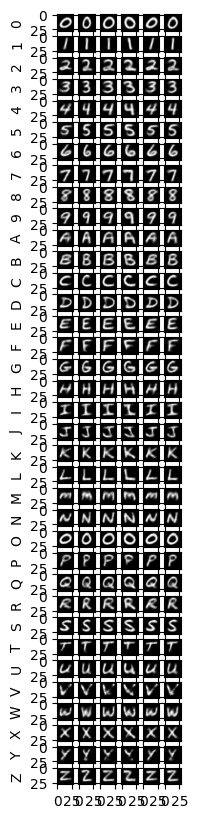

In [15]:
fig = plt.figure(figsize=(15.0, 10.0))
grid = ImageGrid(fig, 121, nrows_ncols=(model.output_size, 6), axes_pad=0.05)

for ax, im in zip(grid, generated_images.cpu().detach()):
    ax.imshow(im, cmap='gray')
    
for i, label in enumerate(labels):
    grid[i*6].set_ylabel(label_to_string(label))

plt.show()